### Setup

In [1]:
import spacy

In [2]:
%%capture
#!python -m spacy download nl_core_news_lg
!python -m spacy download en_core_web_lg

In [3]:
import en_core_web_lg
nlp = en_core_web_lg.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [4]:
doc.vector[:10]

array([-0.0693734 ,  0.26776582, -0.13480794,  0.026144  ,  0.0945714 ,
       -0.1304826 ,  0.0398684 , -0.30131537,  0.0163348 ,  2.28744   ],
      dtype=float32)

In [5]:
import pandas as pd
import numpy as np

In [30]:
pd.read_csv("aut_semdis_input.csv").head()

,id,item,response,response_id,object,respondent_id,temperature
0,1,chair,doorstop,2022040001,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
1,2,chair,start a fire,2022040002,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
2,3,chair,prop up a table or chair leg,2022040003,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
3,4,chair,paperweight,2022040004,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
4,5,chair,make art such as by decoupaging it onto a canv...,2022040005,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67


In [19]:
dat = pd.read_csv("human_aut_response.csv")
dat#.groupby('user_id')[['participantnr']].value_counts('participantnr')
#dat.groupby('user_id')[['participantnr','AUT-response_id']].value_counts('AUT-response_id')
dat

,user_id,participantnr,AUT-response_id,object,response
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag
...,...,...,...,...,...
4691,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45030,tin can,String telephone
4692,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45031,tin can,in artwork
4693,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45032,tin can,desk tidy/holding stationary
4694,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45033,tin can,collecting money/change


In [32]:
# rename columns to conform with pilot data
dat = dat.rename(columns={"AUT-response_id":"response_id", "participantnr":"respondent_id"})

# add an 'item' column to conform with the pilot data (not sure what it should be.. does it matter?)
dat['item'] = 'chair'
dat

,user_id,respondent_id,response_id,object,response,item
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb,chair
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery,chair
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher,chair
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn,chair
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag,chair
...,...,...,...,...,...,...
4691,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45030,tin can,String telephone,chair
4692,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45031,tin can,in artwork,chair
4693,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45032,tin can,desk tidy/holding stationary,chair
4694,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45033,tin can,collecting money/change,chair


### Compute semantic distances between response and target object embeddings

We compute both the Euclidean distances and the cosine distances (defined as 1 minus the cosine similarity).

In [33]:
def nlpSRdocvec(doc, keep_sw = False):
    """Compute document vector with stopwords removed"""
    return sum([w.vector for w in doc if keep_sw or not w.is_stop], doc.vector*0)

eucl_item_resp = [np.linalg.norm(nlpSRdocvec(x) - nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.item.values), nlp.pipe(dat.response.values))]
eucl_objc_resp = [np.linalg.norm(nlpSRdocvec(x) - nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.object.values), nlp.pipe(dat.response.values))]


In [34]:
#cos_sim = lambda x,y: np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0
def cos_sim(x,y):
    """Compute cosine similarity between vectors 'x' and 'y'. 
    If any of the two vectors has length (norm) 0, 0 is returned."""
    import numpy as np
    xTy = np.dot(x,y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return  xTy / (norm_x * norm_y) if norm_x > 0 and norm_y > 0 else 0


cos_dist_item_resp = [1-cos_sim(nlpSRdocvec(x),nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.item.values), nlp.pipe(dat.response.values))]


Inspect the computed cosine distances: Are they regular? Are there any problems like not-a-numbers?

nr of errors:  0
 elements with error: []


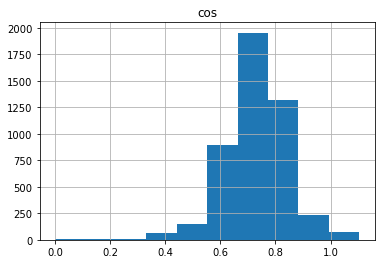

In [35]:
pd.DataFrame({"cos":cos_dist_item_resp}).hist()
print("nr of errors: ", np.sum(np.isnan(cos_dist_item_resp)))
print(" elements with error: %s" % (np.where(np.isnan(cos_dist_item_resp) == True)))

Investigate the above errors (if there are any):

In [38]:

if False: # there were no errors for 'human_aut_response.csv'
    
    print(dat.iloc[971]) # in the pilot case 971 gave an NaN and is investigated here
    nlp(dat.iloc[971].response).vector
    
else:
    
    print('no errors to investigate')

no errors to investigate


Fix any cases by hand if can be:

In [42]:
if False: # there were no errors for 'human_aut_response.csv'
    
    cos_dist_item_resp[971] = 1-cos_sim(nlp("fire lighter").vector, nlp("chair").vector) 
    print('Fixed problematic cases by hand. Check code!')
    
else:
    
    print('Nothing to fix.')

Nothing to fix.


Compute the cosine distances&mdash;i.e., 1-cosine similarity (!)&mdash;between the 'object' and 'response' embeddings:

In [40]:
cos_dist_objc_resp = [1-cos_sim(nlpSRdocvec(x),nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.object.values), nlp.pipe(dat.response.values))]


Correct any problematic cases identified earlier by hand, if necessary:

In [41]:
if False: # there were no errors for 'human_aut_response.csv'
    
    cos_dist_objc_resp[971] = 1-cos_sim(nlp("fire lighter").vector, nlp("book").vector) 
    print('Corrected problematic cases by hand. Check code!')

else:
    
    print('Nothing to correct by hand.')

Nothing to correct by hand.


### Write semantic distances to file

Augment data frame with the distances:

In [43]:
dat['eucl_item_resp'] = eucl_item_resp
dat['eucl_objc_resp'] = eucl_objc_resp
dat['cos_dist_item_resp'] = cos_dist_item_resp
dat['cos_dist_objc_resp'] = cos_dist_objc_resp

In [44]:
dat

,user_id,respondent_id,response_id,object,response,item,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb,chair,8.546968,8.013143,0.824967,0.732309
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery,chair,11.685653,12.155675,0.716931,0.790782
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher,chair,9.233773,10.531011,0.595530,0.795708
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn,chair,8.791459,7.873101,0.989949,0.799006
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag,chair,11.836369,11.581881,0.859517,0.823172
...,...,...,...,...,...,...,...,...,...,...
4691,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45030,tin can,String telephone,chair,11.349264,11.574689,0.738724,0.781443
4692,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45031,tin can,in artwork,chair,8.841945,8.989683,0.820508,0.866333
4693,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45032,tin can,desk tidy/holding stationary,chair,15.378700,17.325891,0.452562,0.711372
4694,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45033,tin can,collecting money/change,chair,14.823507,14.819868,0.759585,0.763787


In [55]:
dat.to_csv("human_aut_response_w_dists.csv",index=False)

### Compute semantic distances between subsequent responses within respondents

In [56]:
dat = pd.read_csv("human_aut_response_w_dists.csv")
dat #= dat.drop(['Unnamed: 0'], axis=1)

,user_id,respondent_id,response_id,object,response,item,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb,chair,8.546967,8.013143,0.824967,0.732309
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery,chair,11.685653,12.155675,0.716931,0.790782
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher,chair,9.233773,10.531011,0.595530,0.795708
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn,chair,8.791459,7.873101,0.989949,0.799006
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag,chair,11.836369,11.581881,0.859517,0.823172
...,...,...,...,...,...,...,...,...,...,...
4691,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45030,tin can,String telephone,chair,11.349264,11.574689,0.738724,0.781443
4692,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45031,tin can,in artwork,chair,8.841945,8.989683,0.820508,0.866333
4693,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45032,tin can,desk tidy/holding stationary,chair,15.378700,17.325891,0.452562,0.711372
4694,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45033,tin can,collecting money/change,chair,14.823507,14.819868,0.759585,0.763787


In [64]:
from scipy.spatial.distance import cosine
cos_sim = lambda x,y: np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0
cos_sim = lambda x,y: 1-cosine(x,y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0

def cos_sim(x,y):
    """An attempt to obtain a safer version of the cosine similarity that doesn't produce values larger than 1. It fails misserably"""
    normx = np.linalg.norm(x)
    normy = np.linalg.norm(y)
    if not normx > 0 or not normy > 0:
        return 0
    normxy = np.linalg.norm(x-y)
    return 0.5*(normx/normy + normy/normx - normxy**2/(normx*normy))

# let's just go back to the old definition of the function
cos_sim = lambda x,y: cosine(x,y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0

In [58]:
def nlpSR(string, keep_sw = False):
    """Compute document vector with stopwords removed"""
    doc = nlp(string)
    return sum([w.vector for w in doc if keep_sw or not w.is_stop], doc.vector*0)

def conseq_semdis(df):
    """Compute semantic distances of consequtive responses in df"""
    resp = df.response.values
    if len(resp) > 1:
        csq_semdis = [2]+[1-cos_sim(nlpSR(resp[i+1]),nlpSR(resp[i])) for i in range(len(df)-1)]
    else:
        csq_semdis = [2]
    df['semdis_prev'] = csq_semdis
    return df

dat2 = dat.sort_values(['respondent_id','response_id','object']).groupby('respondent_id').apply(conseq_semdis)
dat2

,user_id,respondent_id,response_id,object,response,item,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp,semdis_prev
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb,chair,8.546967,8.013143,0.824967,0.732309,2.000000
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery,chair,11.685653,12.155675,0.716931,0.790782,0.240110
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher,chair,9.233773,10.531011,0.595530,0.795708,0.186543
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn,chair,8.791459,7.873101,0.989949,0.799006,0.149387
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag,chair,11.836369,11.581881,0.859517,0.823172,0.092401
...,...,...,...,...,...,...,...,...,...,...,...
4695,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45034,tin can,keeping tolietries in,chair,7.513057,7.846577,0.754737,0.852159,0.577505
4686,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45157,book,a press/flowerpress,chair,9.768176,9.665143,0.742870,0.754149,0.188902
4687,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45158,book,hiding things inside,chair,13.382107,12.841822,0.706156,0.637772,0.267186
4688,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45159,book,stool to reach something higer upo,chair,13.608183,15.019193,0.703917,0.937254,0.265924


In [59]:
np.where(dat2.semdis_prev.values > 1)
#1-cosine(nlpSR(tmp.response.values[3]),nlpSR(tmp.object.values[3]))
#tmp[tmp.respondent_id == 'BP20160025']
#1-cosine(nlpSR(tmp.response.values[3]),nlpSR(tmp.object.values[3]))
#tmp.groupby('object').apply(conseq_semdis)
#tmp.iloc[4:6].groupby('object').apply(conseq_semdis)
#1-cos_sim(nlpSR(tmp.iloc[4:6].response.values[0]), nlpSR(tmp.iloc[4:6].response.values[1]))

(array([   0,   22,   42,   61,   76,  106,  123,  151,  172,  183,  187,
         210,  233,  254,  266,  277,  297,  306,  320,  342,  361,  378,
         385,  399,  426,  444,  457,  472,  490,  499,  511,  528,  543,
         570,  578,  603,  615,  645,  667,  687,  706,  707,  738,  745,
         761,  768,  785,  803,  814,  823,  838,  856,  872,  898,  907,
         913,  927,  947,  954,  966,  977,  993, 1009, 1039, 1055, 1073,
        1085, 1103, 1106, 1121, 1129, 1149, 1160, 1173, 1196, 1204, 1221,
        1246, 1266, 1275, 1298, 1318, 1346, 1363, 1380, 1391, 1406, 1415,
        1436, 1449, 1462, 1477, 1492, 1520, 1530, 1543, 1555, 1578, 1588,
        1610, 1633, 1652, 1667, 1692, 1700, 1718, 1744, 1750, 1769, 1799,
        1813, 1834, 1856, 1870, 1884, 1898, 1904, 1943, 1947, 1973, 1988,
        2010, 2032, 2043, 2053, 2078, 2100, 2121, 2143, 2168, 2192, 2204,
        2221, 2247, 2266, 2279, 2286, 2297, 2302, 2318, 2350, 2363, 2375,
        2386, 2400, 2409, 2425, 2446, 

<AxesSubplot:>

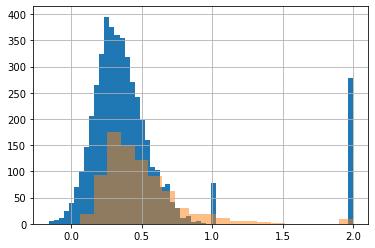

In [63]:
dat2.semdis_prev.hist(bins=60)
dat2.groupby(['respondent_id','object']).mean().semdis_prev.hist(alpha=0.5,bins=20)

In [61]:
!ls

aut_semdis_input.csv                  human_aut_response_w_dists.csv
aut_semdis_input_w_dists.csv          semdis_computations_spacy.ipynb
human_aut_response.csv                semdis_human+gpt3_differences_R.ipynb


In [314]:
dat2.to_csv("aut_semdis_input_w_dists.csv")
!mv *.csv ./aut_pilot_ICCC22/semdis/.

In [70]:
%cd /Users/raoul/Documents/PythonEnvironments/Claire GPT-3 creativiteit dingen/creAI-gpt3/
%ls -la

/Users/raoul/Documents/PythonEnvironments/Claire GPT-3 creativiteit dingen/creAI-gpt3
total 0
drwxr-xr-x@  7 raoul  staff  224 Aug 30 11:46 ./
drwxr-xr-x@  6 raoul  staff  192 Aug 30 11:46 ../
drwxr-xr-x@ 15 raoul  staff  480 Aug 30 12:38 .git/
drwxr-xr-x@  3 raoul  staff   96 Aug 30 11:06 .ipynb_checkpoints/
-rw-r--r--   1 raoul  staff    0 May 26 12:10 README.md
drwxr-xr-x@  5 raoul  staff  160 Aug 30 11:46 aut_examples_experiment/
drwxr-xr-x@ 13 raoul  staff  416 Aug 30 11:25 aut_pilot_ICCC22/


In [71]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   aut_pilot_ICCC22/semdis/semdis_computations_spacy.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	aut_examples_experiment/semdis/
	aut_pilot_ICCC22/.ipynb_checkpoints/
	aut_pilot_ICCC22/semdis/.ipynb_checkpoints/

no changes added to commit (use "git add" and/or "git commit -a")


In [72]:
#!git rm ./aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
#!git rm ./aut_pilot_ICCC22/semdis_computations_spacy.ipynb
#!git rm ./aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb
#!mv *.csv ./aut_pilot_ICCC22/semdis/.
#!git add ./aut_pilot_ICCC22/semdis/*
!git add ./aut_examples_experiment/*
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   aut_examples_experiment/semdis/.ipynb_checkpoints/semdis_computations_spacy-checkpoint.ipynb
	new file:   aut_examples_experiment/semdis/.ipynb_checkpoints/semdis_human+gpt3_differences_R-checkpoint.ipynb
	new file:   aut_examples_experiment/semdis/aut_semdis_input.csv
	new file:   aut_examples_experiment/semdis/aut_semdis_input_w_dists.csv
	new file:   aut_examples_experiment/semdis/human_aut_response.csv
	new file:   aut_examples_experiment/semdis/human_aut_response_w_dists.csv
	new file:   aut_examples_experiment/semdis/semdis_computations_spacy.ipynb
	new file:   aut_examples_experiment/semdis/semdis_human+gpt3_differences_R.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   aut_pilot_ICCC22/semdis

In [179]:
#!git commit -a -m 'recomputed semantic distances with stop words removed'

[master c5e6cdd] removed old files
 Committer: Raoul Grasman <raoul@Raouls-MacBook-Air-2021.local>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 6 files changed, 2444 insertions(+), 5010 deletions(-)
 delete mode 100644 aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
 rewrite aut_pilot_ICCC22/semdis/aut_semdis_input_w_dists.csv (96%)
 delete mode 100644 aut_pilot_ICCC22/semdis_computations_spacy.ipynb
 delete mode 100644 aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb


In [181]:
#!git config --global user.email "rgrasman@uva.nl"

In [183]:
#!git commit --amend --reset-author -m 'Removed old files'

[master 0172eaa] Removed old files
 6 files changed, 2444 insertions(+), 5010 deletions(-)
 delete mode 100644 aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
 rewrite aut_pilot_ICCC22/semdis/aut_semdis_input_w_dists.csv (96%)
 delete mode 100644 aut_pilot_ICCC22/semdis_computations_spacy.ipynb
 delete mode 100644 aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb


In [325]:
!git commit -a -m 'computed semantic distances for human_'

[master 958fb0d] analyzed sequential semantic distances
 1 file changed, 14 insertions(+), 44 deletions(-)


In [ ]:
!git push

Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 8 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.56 MiB | 1.17 MiB/s, done.
Total 12 (delta 7), reused 0 (delta 0), pack-reused 0
